In [1]:
import torch
import pyro
import pyro.distributions as dist
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from pyro.infer import MCMC, NUTS, HMC
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Practical exercises with Variational Inference

In [3]:
# Example data
true_mean = 5
true_std = 1
n_samples = 100
x = true_mean + true_std * torch.randn(n_samples) # Generate n_samples random noisy data points with mean 65 and standard deviation 3

1 - Start from the example seen the last week in class. Extend it to estimate a posterior distribution for the variance.

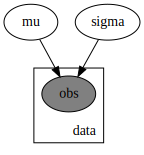

In [4]:
# The model defines the actual posterior by specifying prior and likelihood.
# We need to define how observations are sampled from it.

def model(x):
    # Introduce a prior
    mu_prior = dist.Normal(0.0, 1.0) # Normal prior distribution over mu
    sigma_prior = dist.Uniform(0.0, 20.0)  # Uniform prior distribution over sigma
    
    mu = pyro.sample('mu', mu_prior) # Sample mu from the prior distribution
    sigma = pyro.sample('sigma', sigma_prior)  # Sample sigma from the prior distribution

    # Define the likelihood function; 'pyro.plate' is used to indicate a batch of data points
    with pyro.plate('data', len(x)):
        # Sample the observed data from a Normal distribution with mean mu and standard deviation sigma
        pyro.sample('obs', dist.Normal(mu, sigma), obs=x)
        
pyro.render_model(model, model_args=(x,))

In [5]:
# The guide defines the variational distribution and how observations are sampled from it

def guide(x):
    # Here we create a mu and sigma for the Gaussian variational approximation of mu
    theta_mu = pyro.param('theta_mu', torch.randn(1))  # Initialize theta_mu for the variational distribution
    tau_mu = pyro.param('tau_mu', torch.exp(torch.randn(1)), constraint=dist.constraints.positive)  # Initialize tau_mu for the variational distribution, ensuring positivity
    
    theta_sigma = pyro.param('theta_sigma', torch.exp(torch.rand(1)), constraint=dist.constraints.positive)  # Initialize theta_sigma for the variational distribution
    tau_sigma = pyro.param('tau_sigma', torch.exp(torch.rand(1)), constraint=dist.constraints.positive)  # Initialize tau_sigma for the variational distribution, ensuring positivity

    # Sample z from the variational distribution
    pyro.sample('mu', dist.Normal(theta_mu, tau_mu))
    pyro.sample('sigma', dist.LogNormal(theta_sigma, tau_sigma))

In [6]:
# At this point we can write an optimization routine as we do in PyTorch

def optimisation(x, n_steps=1000, lr=1e-3):
    # Clear any existing parameters in the Pyro parameter store
    pyro.clear_param_store()

    # Define the optimizer and SVI
    adam_params = {'lr': lr}  # Set learning rate for the Adam optimizer
    optimizer = Adam(adam_params)  # Initialize the Adam optimizer for the optimization of the ELBO
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())  # Initialize SVI with the model, guide, optimizer, and loss function as the ELBO
    
    losses = []  # List to store loss values

    # Perform optimization
    for step in range(n_steps):
        loss = svi.step(x)  # Perform a single optimization step
        
        # Record the loss
        losses.append(loss)  # Append the loss to the list
        
        # Print progress every 500 steps
        if (step + 1) % 500 == 0:
            print(f'Step {step + 1} - Loss: {loss:.2f}')

    return pyro.param('theta_mu').item(), pyro.param('tau_mu').item(), pyro.param('theta_sigma').item(), pyro.param('tau_sigma').item(), losses

In [8]:
# Perform the optimisation
theta_mu, tau_mu, theta_sigma, tau_sigma, losses = optimisation(x, n_steps=5000, lr=1e-2)

ValueError: Error while computing log_prob at site 'sigma':
Expected value argument (Tensor of shape (1,)) to be within the support (Interval(lower_bound=0.0, upper_bound=20.0)) of the distribution Uniform(low: 0.0, high: 20.0), but found invalid values:
tensor([38.0026], grad_fn=<ExpBackward0>)
Trace Shapes:    
 Param Sites:    
Sample Sites:    
      mu dist   |
        value 1 |
     log_prob 1 |
   sigma dist   |
        value 1 |

In [ ]:
# Plot the solution and the loss over time
fig,ax=plt.subplots(1,3,figsize=(12,3))
plt.sca(ax[0])
plt.plot(losses)
plt.xlabel('Step')
plt.title('Loss')

z=torch.linspace(-2, 10, 1000)

plt.sca(ax[1])
q_mu=scipy.stats.norm.pdf(x=z, loc=theta_mu, scale=tau_mu)
plt.plot(z, q_mu)
plt.xlabel(r'mu')
plt.title(r'$q(mu)$')

plt.sca(ax[2])
q_sigma=scipy.stats.lognorm.pdf(x=z, s=1.0, loc=theta_sigma, scale=tau_sigma)
plt.plot(z, q_sigma)
plt.xlabel(r'sigma')
plt.title(r'$q(sigma)$')

plt.tight_layout()
plt.show()